# Searching for Dark Matter in ATLAS Proton-Proton Experiments Using Genetic Algorithms

#### Rohan Arni

In [35]:
import numpy as np
import pandas as pd
from deap import base, creator, tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import six
from math import log10, floor
from scipy import stats

In [36]:
dataset = pd.read_csv('data/data.csv')
subset_data = dataset.sample(n=1000, random_state=42)

In [3]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0, title='', ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
        if title:
            fig.suptitle(title, fontsize=font_size+2, color=header_color)

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, rowLabels=data.index, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax.get_figure(), ax



In [4]:
def round_to_significant_figures(df, sig_figures):
    def round_value(x):
        try:
            return round(x, sig_figures - int(floor(log10(abs(x)))) - 1) if x != 0 else 0
        except (ValueError, TypeError):
            return x 
    return df.applymap(round_value)

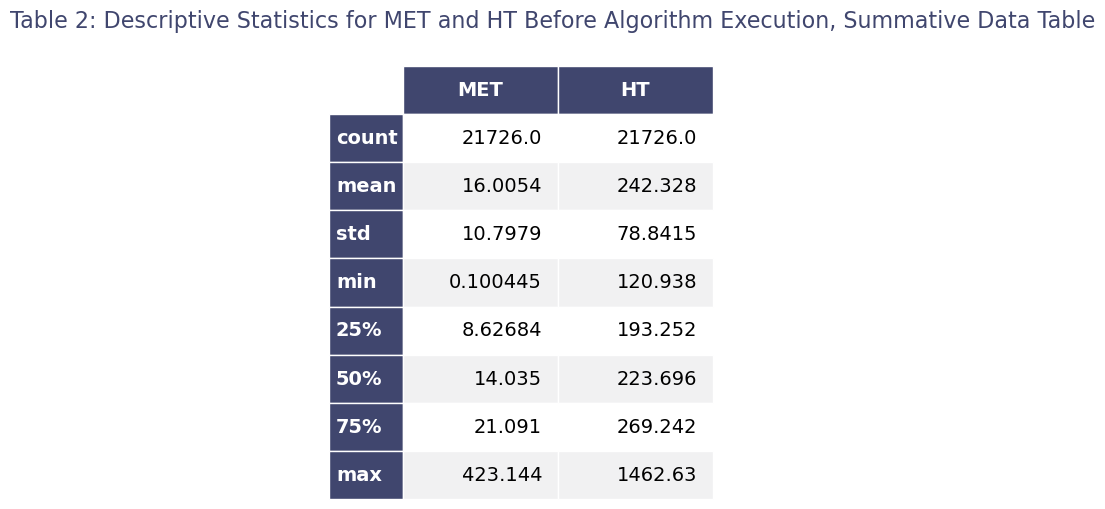

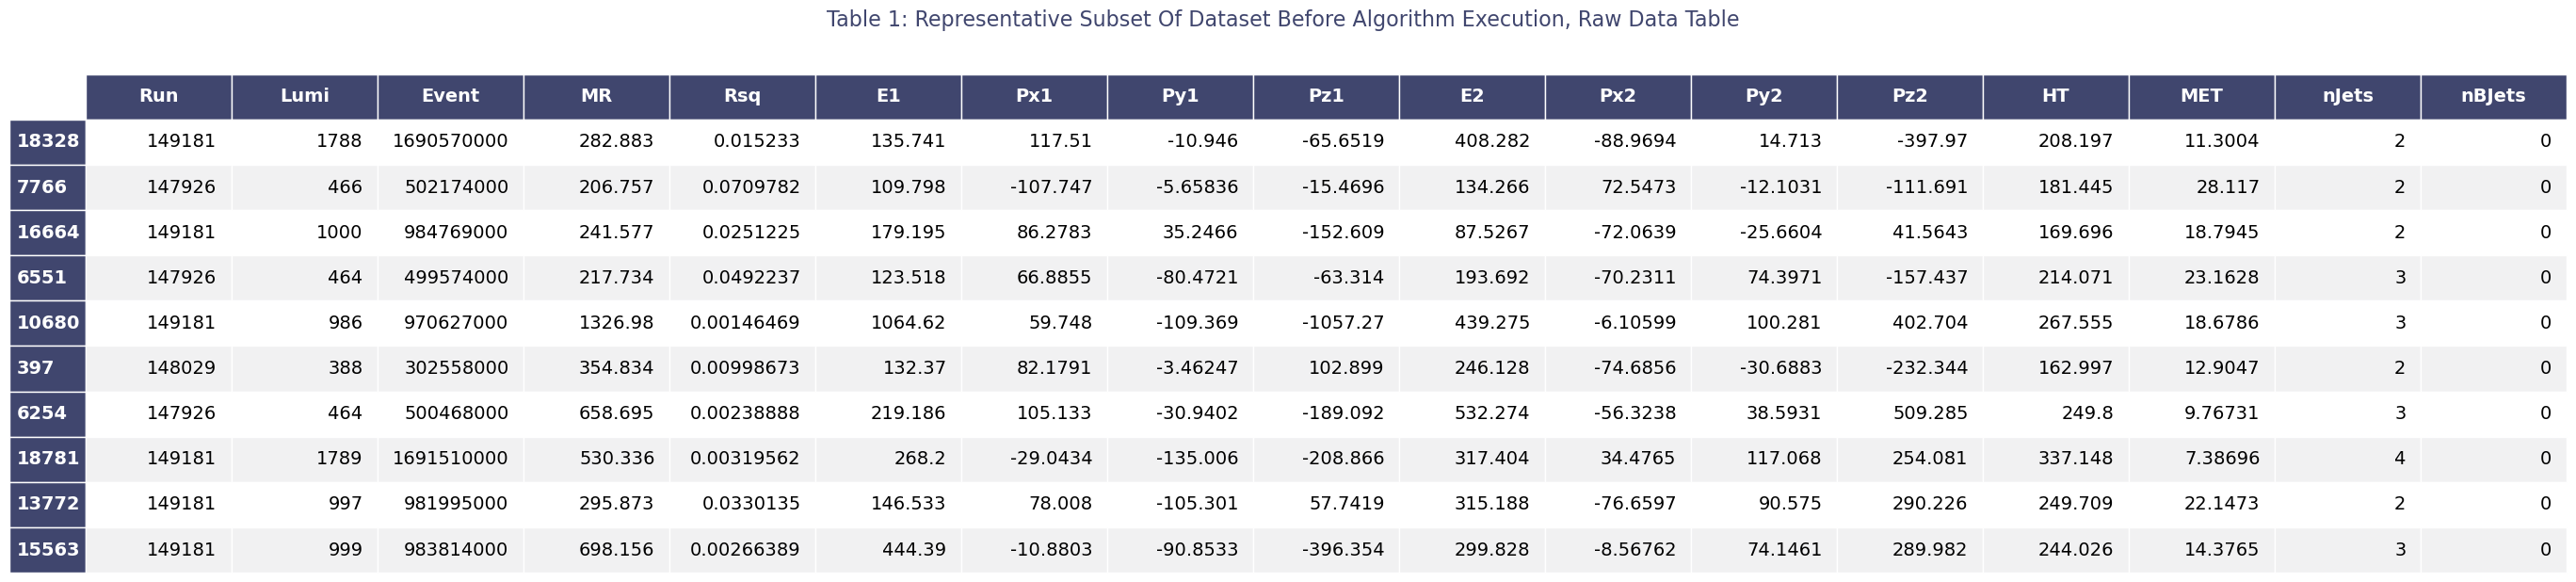

In [5]:
descriptive_stats = dataset[['MET', 'HT']].describe()
subset_data = dataset.sample(n=10, random_state=1)

rounded_descriptive_stats = round_to_significant_figures(descriptive_stats, 6)
rounded_subset_data = round_to_significant_figures(subset_data, 6)

fig1_rounded, ax1_rounded = render_mpl_table(rounded_descriptive_stats, header_columns=0, col_width=2.0, title="Table 2: Descriptive Statistics for MET and HT Before Algorithm Execution, Summative Data Table")
fig2_rounded, ax2_rounded = render_mpl_table(rounded_subset_data, header_columns=0, col_width=2.0, title="Table 1: Representative Subset Of Dataset Before Algorithm Execution, Raw Data Table ")

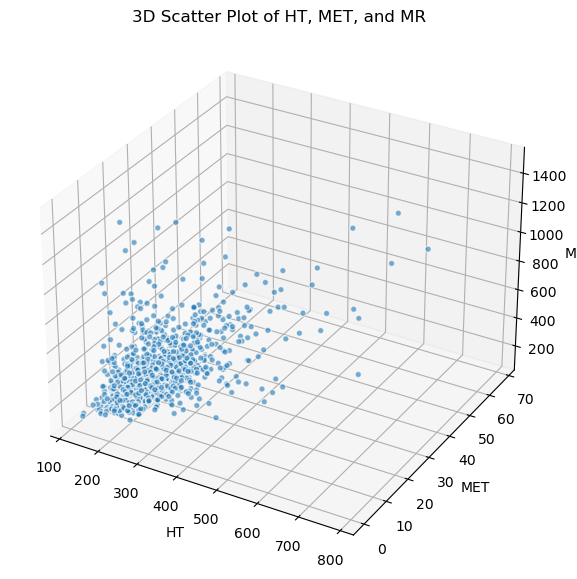

In [6]:
subset_data = dataset.sample(n=1000, random_state=1)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


sc = ax.scatter(subset_data['HT'], subset_data['MET'], subset_data['MR'],  alpha=0.6, edgecolors='w', marker='o')

ax.set_xlabel('HT')
ax.set_ylabel('MET')
ax.set_zlabel('MR')
ax.set_title('3D Scatter Plot of HT, MET, and MR')

plt.show()

In [7]:
BASE_LENGTH = 10
POPULATION_SIZE = 100

Q1_HT = dataset['HT'].quantile(0.25)
Q3_HT = dataset['HT'].quantile(0.75)
Q1_MET = dataset['MET'].quantile(0.25)
Q3_MET = dataset['MET'].quantile(0.75)

IQR_HT = Q3_HT - Q1_HT
IQR_MET = Q3_MET - Q1_MET

multiplier = 1.0
lower_bound_HT = Q1_HT - multiplier * IQR_HT
upper_bound_HT = Q3_HT + multiplier * IQR_HT
lower_bound_MET = Q1_MET - multiplier * IQR_MET
upper_bound_MET = Q3_MET + multiplier * IQR_MET

mean_HT = dataset['HT'].mean()
mean_MET = dataset['MET'].mean()

In [8]:
def calculate_outlierness(individual):
    index = int(''.join(map(str, individual)), 2)
    index = index % len(dataset)
    
    MET_val = dataset['MET'].iloc[index]

    outlierness = 0

    if MET_val > upper_bound_MET and MET_val > mean_MET:
        outlierness += 1

    return outlierness,

In [9]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, BASE_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", calculate_outlierness)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [10]:
def run_ga(NGEN=100, CXPB=0.7, MUTPB=0.2):
    pop = toolbox.population(n=POPULATION_SIZE)

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for gen in range(NGEN):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring

    return pop

def decode_individual(individual):
    return int(''.join(map(str, individual)), 2) % len(dataset) # Convert the binary string to an integer

def get_outlier_data(population):
    outlier_indices = [decode_individual(ind) for ind in population if ind.fitness.values[0] > 0] # Get the indices of the outliers
    outlier_indices = list(set(outlier_indices)) # Remove duplicates
    
    return dataset.iloc[outlier_indices] # Return the outlier data

In [11]:
final_population = run_ga(CXPB=0.7, MUTPB=0.2, NGEN=100)
top_individuals = sorted(final_population, key=lambda x: x.fitness.values[0], reverse=True)
top_individuals

[[1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1,

In [12]:
outlier_data = get_outlier_data(final_population)
number_of_outliers = outlier_data.shape[0]
number_of_outliers

4

In [13]:
def run_ga_experiments(CXPB, MUTPB):
    results_df = pd.DataFrame()

    for i in range(100):
        final_population = run_ga(CXPB=CXPB, MUTPB=MUTPB)
        outlier_data = get_outlier_data(final_population)

        outlier_events = [i+1] + outlier_data['Event'].tolist()

        outlier_df = pd.DataFrame([outlier_events])
        
        results_df = pd.concat([results_df, outlier_df], ignore_index=True)

    num_outliers = results_df.shape[1] - 1
    results_df.columns = ['Run'] + [f'Outlier{i+1}' for i in range(num_outliers)]

    output_path = f"trials/outliers_cxpb_{CXPB}_mutpb_{MUTPB}.csv"
    results_df.to_csv(output_path, index=False)

    print (f"Results saved to {output_path}")
    
run_ga_experiments(CXPB=0.7, MUTPB=0.01)

Results saved to trials/outliers_cxpb_0.7_mutpb_0.01.csv


In [14]:
run_ga_experiments(CXPB=0.7, MUTPB=0.01)
run_ga_experiments(CXPB=0.75, MUTPB=0.05)
run_ga_experiments(CXPB=0.8, MUTPB=0.1)
run_ga_experiments(CXPB=0.85, MUTPB=0.2)
run_ga_experiments(CXPB=0.9, MUTPB=0.3)

Results saved to trials/outliers_cxpb_0.7_mutpb_0.01.csv
Results saved to trials/outliers_cxpb_0.75_mutpb_0.05.csv
Results saved to trials/outliers_cxpb_0.8_mutpb_0.1.csv
Results saved to trials/outliers_cxpb_0.85_mutpb_0.2.csv
Results saved to trials/outliers_cxpb_0.9_mutpb_0.3.csv


In [15]:
ignore_warnings(category=ConvergenceWarning)
def process_data_for_clustering(file_path):
    data = pd.read_csv(file_path)

    outlier_data = pd.concat([data[col] for col in data.columns]).dropna()
    frequency_data = outlier_data.value_counts().reset_index()
    frequency_data.columns = ['Number', 'Frequency']

    max_clusters = min(len(outlier_data), 10)
    n_clusters = np.arange(1, max_clusters + 1)
    bics = []

    for n in n_clusters:
        gmm = GaussianMixture(n_components=n, random_state=0)
        gmm.fit(frequency_data[['Frequency']])
        bics.append(gmm.bic(frequency_data[['Frequency']]))
    optimal_clusters = n_clusters[np.argmin(bics)]

    gmm = GaussianMixture(n_components=optimal_clusters, random_state=0)
    gmm.fit(frequency_data[['Frequency']])
    cluster_labels = gmm.predict(frequency_data[['Frequency']])
    frequency_data['Cluster'] = cluster_labels

    cluster_summary = frequency_data.groupby('Cluster')['Frequency'].agg(['count', 'mean', 'min', 'max'])
    sorted_cluster_indices = cluster_summary['mean'].sort_values().index
    cluster_mapping = {old: new for new, old in enumerate(sorted_cluster_indices, start=1)}
    frequency_data['SortedCluster'] = frequency_data['Cluster'].map(cluster_mapping)

    return frequency_data

def plot_distribution_of_items(frequency_data, title):
    plt.figure(figsize=(7, 6))
    sns.countplot(x='SortedCluster', data=frequency_data, palette='viridis')
    plt.title(title)
    plt.xlabel('Sorted Cluster')
    plt.ylabel('Number of Items')
    plt.show()

def plot_frequency_distribution(frequency_data, title):
    plt.figure(figsize=(7, 6))
    sns.boxplot(x='SortedCluster', y='Frequency', data=frequency_data, palette='viridis')
    plt.title(title)
    plt.xlabel('Sorted Cluster')
    plt.ylabel('Frequency')
    plt.show()


/Users/rohanarni/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


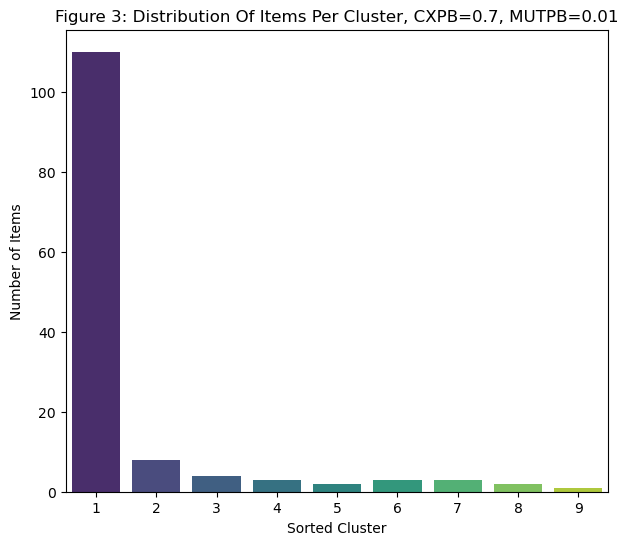

/Users/rohanarni/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


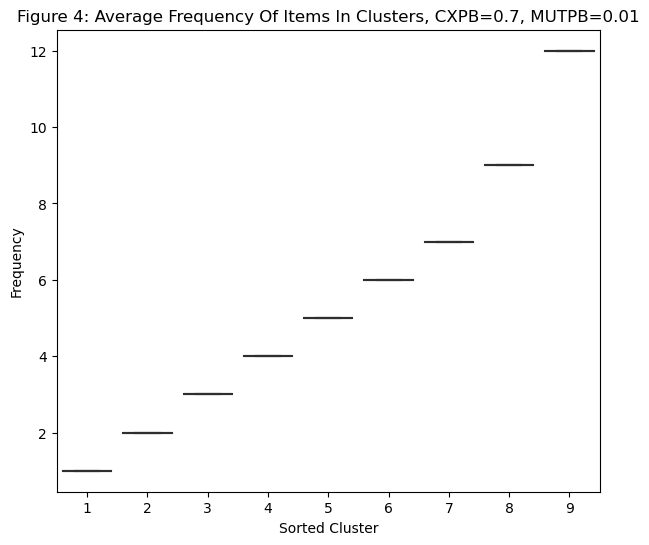

In [16]:
plot_distribution_of_items(process_data_for_clustering('trials/outliers_cxpb_0.7_mutpb_0.01.csv'), title='Figure 3: Distribution Of Items Per Cluster, CXPB=0.7, MUTPB=0.01')
plot_frequency_distribution(process_data_for_clustering('trials/outliers_cxpb_0.7_mutpb_0.01.csv'), title='Figure 4: Average Frequency Of Items In Clusters, CXPB=0.7, MUTPB=0.01')

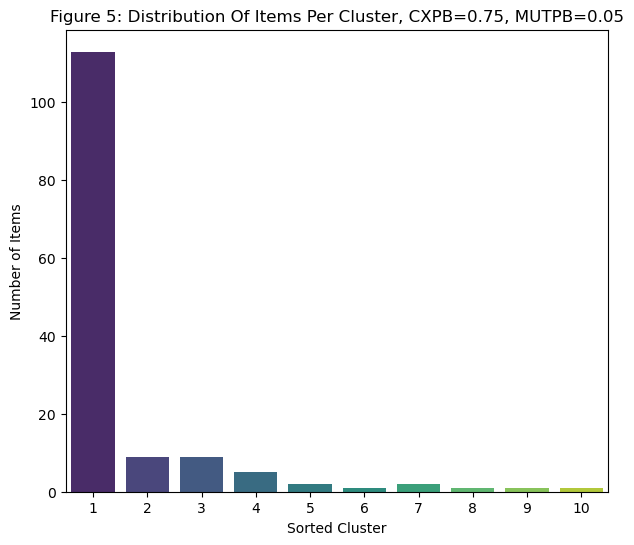

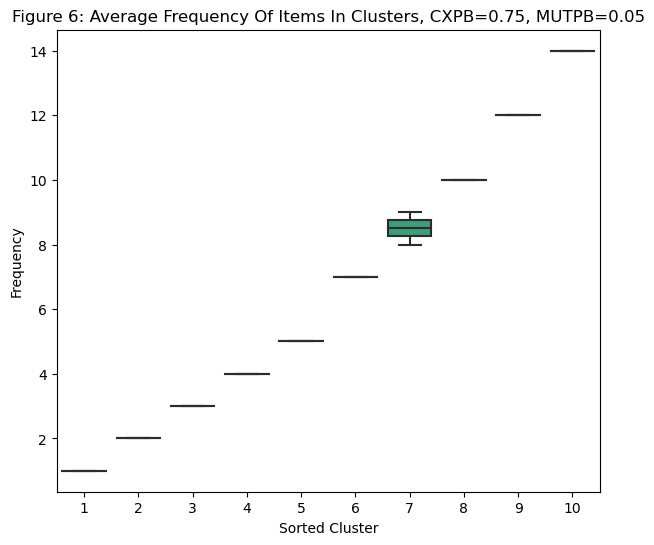

In [17]:
plot_distribution_of_items(process_data_for_clustering('trials/outliers_cxpb_0.75_mutpb_0.05.csv'), title='Figure 5: Distribution Of Items Per Cluster, CXPB=0.75, MUTPB=0.05')
plot_frequency_distribution(process_data_for_clustering('trials/outliers_cxpb_0.75_mutpb_0.05.csv'), title='Figure 6: Average Frequency Of Items In Clusters, CXPB=0.75, MUTPB=0.05')

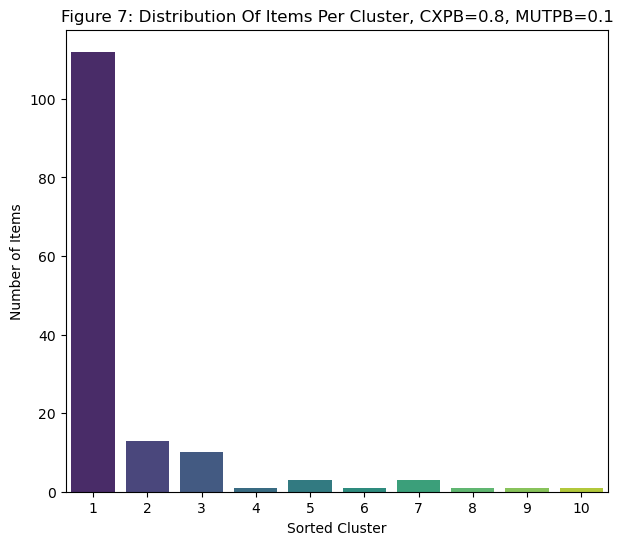

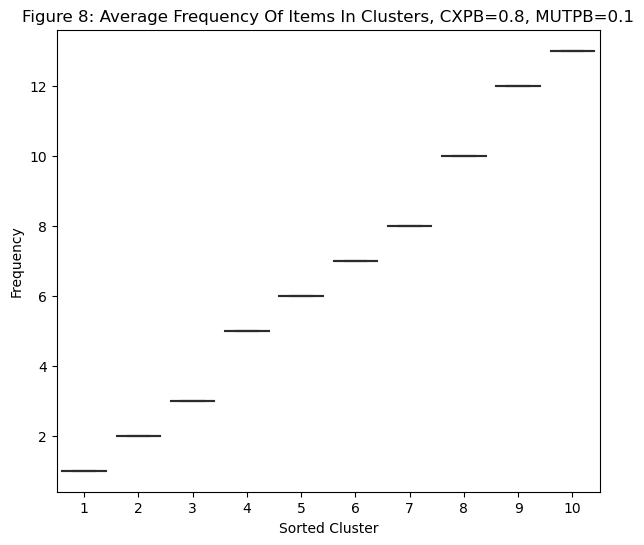

In [18]:
plot_distribution_of_items(process_data_for_clustering('trials/outliers_cxpb_0.8_mutpb_0.1.csv'), title='Figure 7: Distribution Of Items Per Cluster, CXPB=0.8, MUTPB=0.1')
plot_frequency_distribution(process_data_for_clustering('trials/outliers_cxpb_0.8_mutpb_0.1.csv'), title='Figure 8: Average Frequency Of Items In Clusters, CXPB=0.8, MUTPB=0.1')

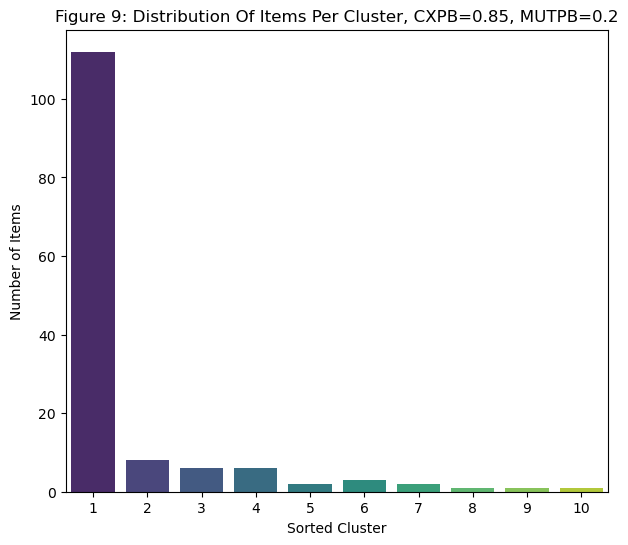

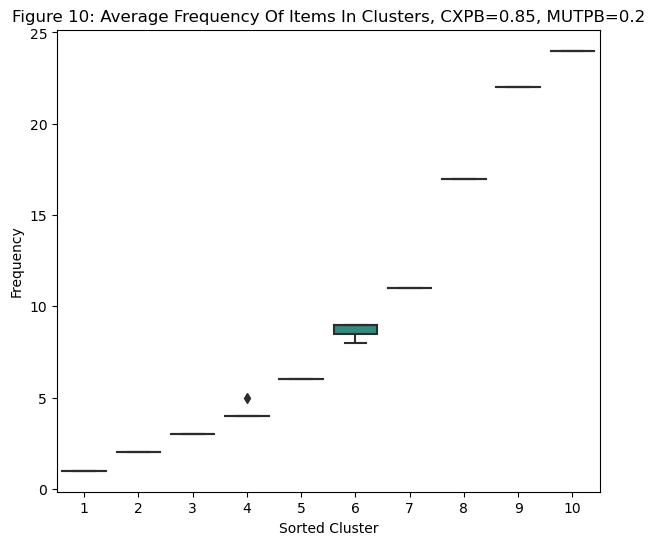

In [19]:
plot_distribution_of_items(process_data_for_clustering('trials/outliers_cxpb_0.85_mutpb_0.2.csv'), title='Figure 9: Distribution Of Items Per Cluster, CXPB=0.85, MUTPB=0.2')
plot_frequency_distribution(process_data_for_clustering('trials/outliers_cxpb_0.85_mutpb_0.2.csv'), title='Figure 10: Average Frequency Of Items In Clusters, CXPB=0.85, MUTPB=0.2')

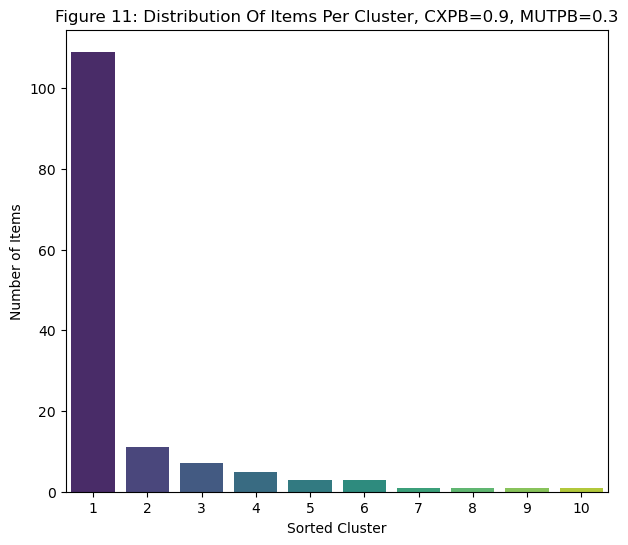

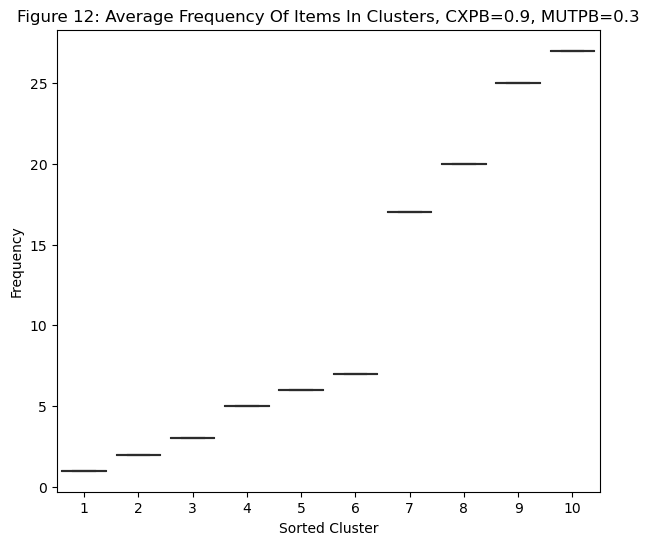

In [20]:
plot_distribution_of_items(process_data_for_clustering('trials/outliers_cxpb_0.9_mutpb_0.3.csv'), title='Figure 11: Distribution Of Items Per Cluster, CXPB=0.9, MUTPB=0.3')
plot_frequency_distribution(process_data_for_clustering('trials/outliers_cxpb_0.9_mutpb_0.3.csv'), title='Figure 12: Average Frequency Of Items In Clusters, CXPB=0.9, MUTPB=0.3')

In [21]:
data = pd.read_csv('results/results_unfiltered.csv')
data_cleaned = data.drop_duplicates()
data_cleaned.to_csv('results/results.csv', index=False)

In [22]:
data_df = pd.read_csv('data/data.csv')
results_df = pd.read_csv('results/results.csv')

print("Columns in data_df:", data_df.columns.tolist())
print("Columns in results_df:", results_df.columns.tolist())

if 'Event' in data_df.columns and 'Event' in results_df.columns:
    results_event = pd.merge(data_df, results_df, on='Event')
    print(results_event.head())
else:
    print("The 'Event' column is missing in one of the DataFrames.")


Columns in data_df: ['Run', 'Lumi', 'Event', 'MR', 'Rsq', 'E1', 'Px1', 'Py1', 'Pz1', 'E2', 'Px2', 'Py2', 'Pz2', 'HT', 'MET', 'nJets', 'nBJets']
Columns in results_df: ['Event']
      Run  Lumi      Event       MR       Rsq       E1       Px1       Py1  \
0  148029   388  302352893  807.266  0.006091  655.939   -93.081   11.6568   
1  148029   388  302396479  403.615  0.052452  266.604   193.371   74.6928   
2  148029   388  302820112  374.668  0.046841  241.817  -114.461  152.9090   
3  148029   389  303117826  583.117  0.010307  243.392    48.579  -64.6525   
4  148029   389  303880165  500.041  0.044794  295.260  -218.341  153.4860   

         Pz1       E2       Px2         Py2       Pz2       HT      MET  \
0 -557.89000  287.792   58.7969   -0.715103  281.4790  365.481  42.0933   
1  165.62200  385.284 -161.7880  -59.868900  343.3310  379.805  41.2234   
2   -4.50779  264.122   88.8977 -131.544000 -136.1320  397.282  34.4156   
3 -229.10300  468.096  -31.8635   22.551600  350.4940 

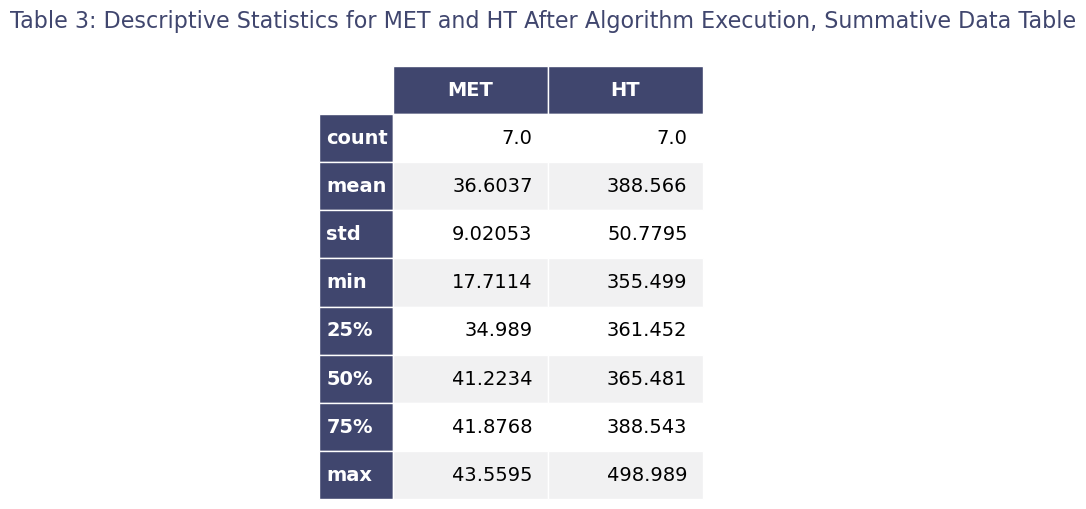

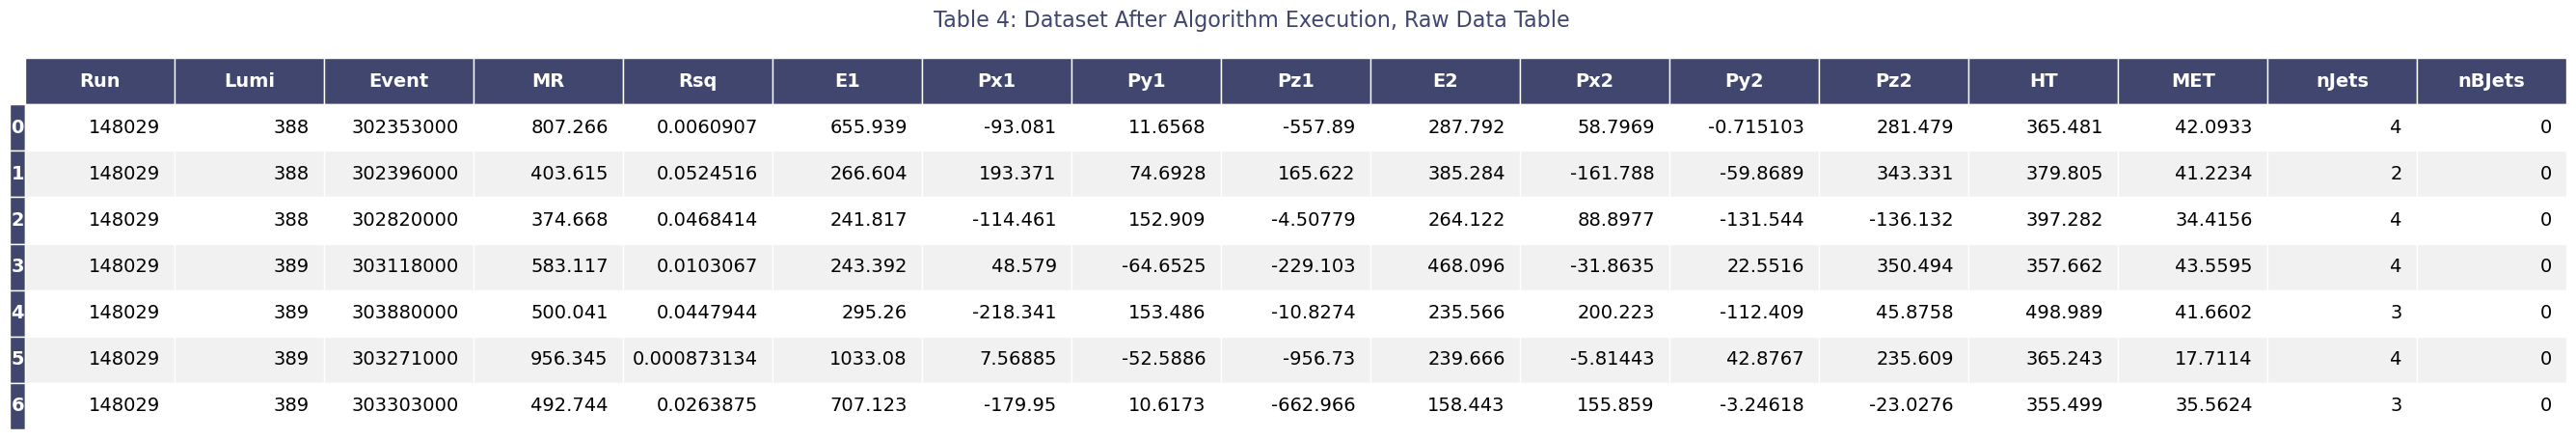

In [23]:
descriptive_stats = results_event[['MET', 'HT']].describe()

rounded_descriptive_stats = round_to_significant_figures(descriptive_stats, 6)
rounded_subset_data = round_to_significant_figures(results_event, 6)

fig1_rounded, ax1_rounded = render_mpl_table(rounded_descriptive_stats, header_columns=0, col_width=2.0, title='Table 3: Descriptive Statistics for MET and HT After Algorithm Execution, Summative Data Table')
fig2_rounded, ax2_rounded = render_mpl_table(rounded_subset_data, header_columns=0, col_width=2.0, title='Table 4: Dataset After Algorithm Execution, Raw Data Table ')

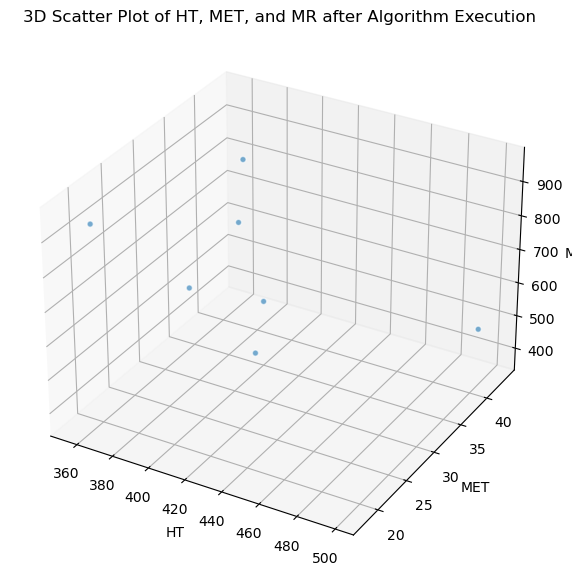

In [24]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(results_event['HT'], results_event['MET'], results_event['MR'],  alpha=0.6, edgecolors='w', marker='o')

ax.set_xlabel('HT')
ax.set_ylabel('MET')
ax.set_zlabel('MR')
ax.set_title('3D Scatter Plot of HT, MET, and MR after Algorithm Execution')

plt.show()

In [34]:
def calculate_p_value(pre_mean, post_mean, pre_std, post_std, pre_n, post_n):

    se_pre = pre_std / (pre_n ** 0.5)
    se_post = post_std / (post_n ** 0.5)

    t_stat = (pre_mean - post_mean) / ((se_pre ** 2 + se_post ** 2) ** 0.5)

    df = (se_pre ** 2 + se_post ** 2) ** 2 / ((se_pre ** 4 / (pre_n - 1)) + (se_post ** 4 / (post_n - 1)))

    p_value = stats.t.sf(abs(t_stat), df) * 2 

    return p_value


In [33]:
calculate_p_value(16.0054, 36.6037, 10.7979, 9.02053, 21726, 7)

0.000928167925631491